# Backtesting

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DecisionTransformerConfig, DecisionTransformerModel
from sklearn.model_selection import train_test_split
import ast
import itertools

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
from variations import Lstm, NoRtgDT, FinRLDataset

In [6]:
def parse_array(s):
    """
    Parses a string representation of a numpy array by direct manipulation.
    Handles multiple spaces, newlines, and scientific notation.
    """
    try:
        # Remove brackets and newlines, strip whitespace
        s_cleaned = s.replace('[', '').replace(']', '').replace('\n', '').strip()
        # Split by space
        parts = s_cleaned.split(' ')
        # Filter out empty strings from multiple spaces and convert to float
        return np.array([float(p) for p in parts if p != ''])
    except Exception as e:
        print(f"FATAL ERROR: Could not parse string: '{s}'")
        raise e

### Plot the Decisioin Transformer Baseline against Nasdaq 100 Benchmark

In [ ]:
df = pd.read_csv("decision_transformer_ready_dataset.csv")
model_path = "decision_transformer_20_lr_3e-5_1000_epochs.pth"

In [ ]:
df['state'] = df['state'].apply(parse_array)
df['action'] = df['action'].apply(parse_array)

df['episode_start'] = df['episode_start'].astype(bool)
episode_starts = df.index[df['episode_start']].tolist()
episode_indices = list(range(len(episode_starts)))
train_ep_indices, val_ep_indices = train_test_split(episode_indices, test_size=0.2, random_state=42)

train_df_indices = []
for ep_idx in train_ep_indices:
    start = episode_starts[ep_idx]
    end = episode_starts[ep_idx+1] if ep_idx + 1 < len(episode_starts) else len(df)
    train_df_indices.extend(range(start, end))

val_df_indices = []
for ep_idx in val_ep_indices:
    start = episode_starts[ep_idx]
    end = episode_starts[ep_idx+1] if ep_idx + 1 < len(episode_starts) else len(df)
    val_df_indices.extend(range(start, end))

train_df = df.iloc[train_df_indices].reset_index(drop=True)
val_df = df.iloc[val_df_indices].reset_index(drop=True)

CONTEXT_LENGTH = 20
train_dataset = FinRLDataset(train_df, context_len=CONTEXT_LENGTH)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

state_dim = train_dataset.state_dim
act_dim = train_dataset.action_dim

config = DecisionTransformerConfig(state_dim=state_dim, act_dim=act_dim, hidden_size=128, n_layer=3, n_head=1, n_inner=4*128)
model = DecisionTransformerModel(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

In [ ]:
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'
trade_df = pd.read_csv('trade_data.csv')

trade_df = trade_df.set_index(trade_df.columns[0])
trade_df.index.names = ['']

stock_dimension = len(trade_df.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

eval_env = StockTradingEnv(df=trade_df, **env_kwargs)

Stock Dimension: 29, State Space: 291


In [ ]:
def evaluate_episode_rtg(model, env, target_return):
    model.eval()
    state, _ = env.reset()
    state = np.array(state)
    done = False
    
    states = torch.from_numpy(state).reshape(1, 1, state_dim).float().to(device)
    actions = torch.zeros((1, 1, act_dim), device=device)
    rewards_history = torch.zeros(1, 1, device=device)
    target_return_tensor = torch.tensor(target_return, device=device, dtype=torch.float32).reshape(1, 1, 1)
    timesteps = torch.tensor(0, device=device).reshape(1, 1)
    episode_return, episode_length = 0, 0
    
    while not done:
        seq_len = states.shape[1]
        attention_mask = torch.ones(1, seq_len, device=device, dtype=torch.long)
        
        model_args = {
            "states": states,
            "actions": actions,
            "rewards": rewards_history,
            "timesteps": timesteps,
            "attention_mask": attention_mask,
            "returns_to_go": target_return_tensor
        }
        
        outputs = model(**model_args)
        action_preds = outputs['action_preds']

        action = action_preds[0, -1].detach().cpu().numpy()
        state, reward, terminated, truncated, _ = env.step(action)
        state = np.array(state)
        done = terminated or truncated

        actions = torch.cat([actions, torch.from_numpy(action).reshape(1, 1, act_dim).float().to(device)], dim=1)
        states = torch.cat([states, torch.from_numpy(state).reshape(1, 1, state_dim).float().to(device)], dim=1)
        rewards_history = torch.cat([rewards_history, torch.tensor([[reward]], device=device, dtype=torch.float32)], dim=1)
        
        reward_tensor = torch.tensor([[[reward]]], device=device, dtype=torch.float32)
        new_rtg = target_return_tensor[:, -1:, :] - reward_tensor
        target_return_tensor = torch.cat([target_return_tensor, new_rtg], dim=1)
        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (episode_length + 1)], dim=1)
        episode_return += reward
        episode_length += 1

        states, actions, rewards_history, target_return_tensor, timesteps = (
            states[:, -CONTEXT_LENGTH:],
            actions[:, -CONTEXT_LENGTH:],
            rewards_history[:, -CONTEXT_LENGTH:],
            target_return_tensor[:, -CONTEXT_LENGTH:],
            timesteps[:, -CONTEXT_LENGTH:]
        )
        
    return env.save_asset_memory()

In [ ]:
df['episode_start'] = df['episode_start'].astype(bool)
episode_starts = df.index[df['episode_start']].tolist()
episode_ends = episode_starts[1:] + [len(df)]
episode_returns = [df.iloc[start:end]['reward'].sum() for start, end in zip(episode_starts, episode_ends)]
target_return_prompt = np.mean(episode_returns)

print(f"\nEvaluating with a Target Return of: {target_return_prompt:.2f}")

account_value_df = evaluate_episode_rtg(model, eval_env, target_return_prompt)

start_date = account_value_df.date.iloc[0]
end_date = account_value_df.date.iloc[-1]


Evaluating with a Target Return of: 439.31


In [57]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import matplotlib.pyplot as plt
%matplotlib inline

benchmark_ticker = 'QQQ' # Nasdaq 100

start_date = account_value_df.date[0]
end_date = account_value_df.date[len(account_value_df)-1]

baseline_df = get_baseline(
    ticker=benchmark_ticker,
    start=start_date,
    end=end_date
)

#  Normalize and merge the baseline data
baseline_df['baseline'] = baseline_df['close'] / baseline_df['close'].iloc[0] * account_value_df['account_value'].iloc[0]
account_value_with_baseline = pd.merge(account_value_df, baseline_df[['baseline']], how='left', left_index=True, right_index=True)

# rename the first column 'index' to 'date'
account_value_to_plot = account_value_with_baseline.rename(columns={'index': 'date'})

print("Calculating performance stats...")
perf_stats_all = backtest_stats(account_value=account_value_to_plot)

# print("--- Performance Stats ---")
# print(perf_stats_all)

# print("Generating backtest plot...")
# backtest_plot(account_value=account_value_to_plot)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (334, 8)
Calculating performance stats...
Annual return          0.235019
Cumulative returns     0.323938
Annual volatility      0.162155
Sharpe ratio           1.386838
Calmar ratio           2.579548
Stability              0.828271
Max drawdown          -0.091108
Omega ratio            1.260789
Sortino ratio          2.114509
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.065932
Daily value at risk   -0.019537
dtype: float64


In [58]:
annual_return = f"{perf_stats_all.loc['Annual return']*100:.2f}%"
sharpe_ratio = f"{perf_stats_all.loc['Sharpe ratio']:.2f}"
max_drawdown = f"{perf_stats_all.loc['Max drawdown']*100:.2f}%"
volatility = f"{perf_stats_all.loc['Annual volatility']*100:.2f}%"
# Calculate Total Return from the account value
total_return = ( (account_value_to_plot['account_value'].iloc[-1] / account_value_to_plot['account_value'].iloc[0]) - 1 ) * 100
total_return_str = f"{total_return:.2f}%"

stats_text = (
    f"Total Return: {total_return_str}\n"
    f"Annual Return: {annual_return}\n"
    f"Sharpe Ratio: {sharpe_ratio}\n"
    f"Max Drawdown: {max_drawdown}\n"
    f"Volatility: {volatility}"
)
print(stats_text)

Total Return: 32.39%
Annual Return: 23.50%
Sharpe Ratio: 1.39
Max Drawdown: -9.11%
Volatility: 16.22%


In [22]:
account_value_to_plot.head()

,date,account_value,baseline
0,2020-07-01,1.000000e+06,1.000000e+06
1,2020-07-02,1.000125e+06,1.006787e+06
2,2020-07-06,1.001285e+06,1.031538e+06
3,2020-07-07,1.000208e+06,1.024432e+06
4,2020-07-08,1.001757e+06,1.037926e+06


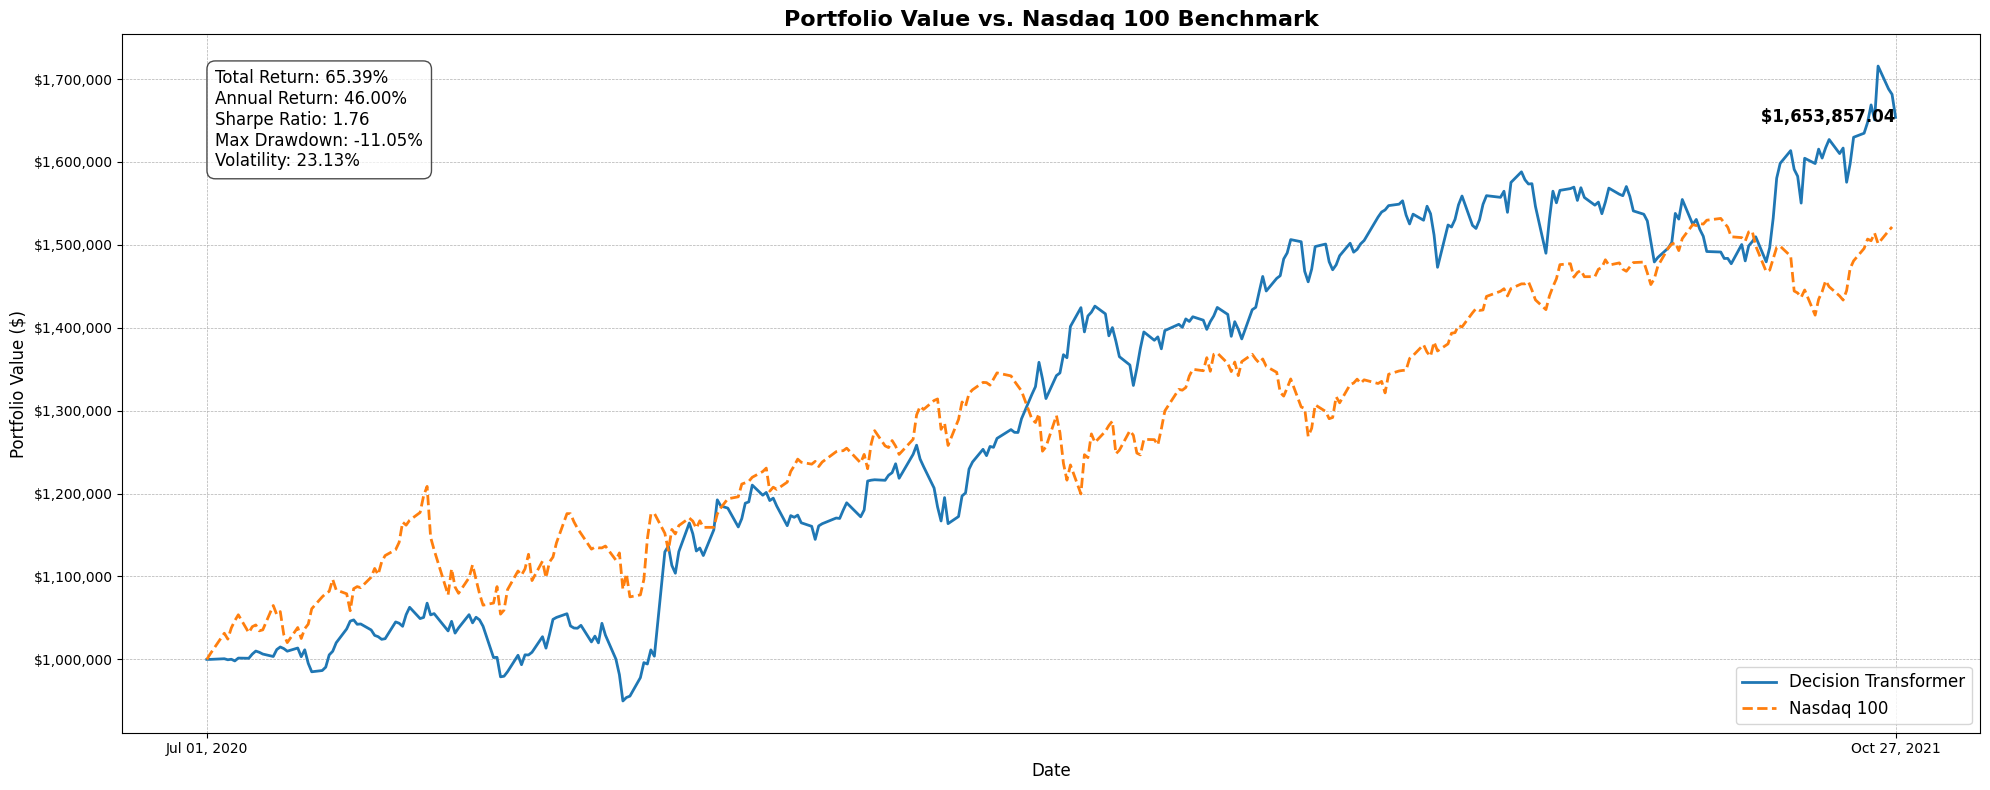

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20, 8))
account_value_to_plot['date'] = pd.to_datetime(account_value_to_plot['date'])

# Decision Transformer's portfolio value
ax.plot(account_value_to_plot['date'], account_value_to_plot['account_value'], lw=2, label='Decision Transformer')

# baseline (benchmark)
ax.plot(account_value_to_plot['date'], account_value_to_plot['baseline'], lw=2, linestyle='--', label='Nasdaq 100')

ax.set_title('Portfolio Value vs. Nasdaq 100 Benchmark', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)

# Format the y-axis to show dollar values
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xticks([start_date, end_date])

# Format the labels for these specific ticks for readability
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))

# Add a legend and grid
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

# Add a final annotation for the portfolio value
final_value = account_value_to_plot['account_value'].iloc[-1]
ax.text(account_value_to_plot['date'].iloc[-1], final_value, f' ${final_value:,.2f}',
        verticalalignment='center', fontsize=12, fontweight='bold', ha='right')

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

plt.tight_layout()
fig.savefig('backtest_plot.png', dpi=300)
plt.show()

### Plot all model variants

- Decision Transformer Baseline
- LSTM
- No-RTG DT

In [3]:
CONTEXT_LENGTH = 20

def run_evaluation_for_model(model_variant=None):
    """
    Runs the evaluation for a single model specified by the model type.
    Returns a dataframe with the account values.
    """
    print(f"\n--- Running Evaluation for model: {model_variant or 'Baseline'} ---")
    
    # Load the offline dataset to determine dimensions and target return
    df = pd.read_csv("decision_transformer_ready_dataset.csv")
    df['state'] = df['state'].apply(parse_array)
    df['action'] = df['action'].apply(parse_array)

    state_dim = len(df['state'].iloc[0])
    act_dim = len(df['action'].iloc[0])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the appropriate model architecture
    model_path = f"saved_models/decision_transformer_{model_variant or 'finrl_baseline'}.pth"
    
    config = DecisionTransformerConfig(
        state_dim=state_dim, act_dim=act_dim, hidden_size=128,
        n_layer=3, n_head=1, n_inner=4*128, max_ep_len=4096
    )
    
    if model_variant == "lstm":
        model = Lstm(state_dim=state_dim, act_dim=act_dim)
    elif model_variant == "no_rtg":
        model = NoRtgDT(config)
    else:  # Baseline
        model = DecisionTransformerModel(config)
    
    print(f"Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Set up the trading environment
    trade_df = pd.read_csv('trade_data.csv')
    trade_df = trade_df.set_index(trade_df.columns[0])
    trade_df.index.names = ['']

    stock_dimension = len(trade_df.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    
    env_kwargs = {
        "hmax": 100, "initial_amount": 1000000,
        "num_stock_shares": [0] * stock_dimension,
        "buy_cost_pct": [0.001] * stock_dimension,
        "sell_cost_pct": [0.001] * stock_dimension,
        "state_space": state_space, "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS, "action_space": stock_dimension,
        "reward_scaling": 1e-4
    }
    eval_env = StockTradingEnv(df=trade_df, **env_kwargs)

    # Determine the target return from the training data
    df['episode_start'] = df['episode_start'].astype(bool)
    episode_starts = df.index[df['episode_start']].tolist()
    episode_ends = episode_starts[1:] + [len(df)]
    episode_returns = [df.iloc[start:end]['reward'].sum() for start, end in zip(episode_starts, episode_ends)]
    target_return_prompt = np.mean(episode_returns)
    print(f"Evaluating with a Target Return of: {target_return_prompt:.2f}")

    # --- Evaluation Loop ---
    state, _ = eval_env.reset()
    state = np.array(state)
    done = False

    states = torch.from_numpy(state).reshape(1, 1, state_dim).float().to(device)
    actions = torch.zeros((1, 1, act_dim), device=device)
    rewards_history = torch.zeros((1, 1, 1), device=device)
    target_return_tensor = torch.tensor(target_return_prompt, device=device, dtype=torch.float32).reshape(1, 1, 1)
    timesteps = torch.tensor(0, device=device).reshape(1, 1)

    while not done:
        with torch.no_grad():
            # Build the argument dictionary for the model forward pass
            model_args = {
                "states": states, "actions": actions, "rewards": rewards_history,
                "returns_to_go": target_return_tensor, "timesteps": timesteps,
                "attention_mask": torch.ones(1, states.shape[1], device=device)
            }

            outputs = model(**model_args)
            action_preds = outputs['action_preds'] if isinstance(outputs, dict) else outputs.action_preds
            action = action_preds[0, -1].detach().cpu().numpy()

        
        state, reward, terminated, truncated, _ = eval_env.step(action)
        state = np.array(state)
        done = terminated or truncated

        # Update sequences for the next step
        actions = torch.cat([actions, torch.from_numpy(action).reshape(1, 1, act_dim).float().to(device)], dim=1)
        states = torch.cat([states, torch.from_numpy(state).reshape(1, 1, state_dim).float().to(device)], dim=1)
        rewards_history = torch.cat([rewards_history, torch.tensor([[[reward]]], device=device).float()], dim=1)
        
        new_rtg = target_return_tensor[:, -1:, :] - torch.tensor([[[reward]]], device=device).float()
        target_return_tensor = torch.cat([target_return_tensor, new_rtg], dim=1)
        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (timesteps.max() + 1)], dim=1)

        # Trim sequences to context length
        states, actions, rewards_history, target_return_tensor, timesteps = (
            states[:, -CONTEXT_LENGTH:], actions[:, -CONTEXT_LENGTH:], rewards_history[:, -CONTEXT_LENGTH:],
            target_return_tensor[:, -CONTEXT_LENGTH:], timesteps[:, -CONTEXT_LENGTH:]
        )
    
    # Return the performance dataframe
    return eval_env.save_asset_memory()

In [4]:
def evaluate_and_plot_all():
    """
    Evaluates all models and plots their performance against benchmarks on a single graph.
    """
    # --- Run evaluations for all models ---
    df_baseline = run_evaluation_for_model(model_variant=None)
    df_lstm = run_evaluation_for_model(model_variant="lstm")
    df_no_rtg = run_evaluation_for_model(model_variant="no_rtg")

    # --- Combine results for plotting ---
    plot_df = pd.DataFrame()
    plot_df['date'] = pd.to_datetime(df_baseline['date'])
    plot_df['Baseline DT'] = df_baseline['account_value'].values
    plot_df['LSTM'] = df_lstm['account_value'].values
    plot_df['No RTG DT'] = df_no_rtg['account_value'].values
    
    # --- Get Benchmark Data ---
    start_date = plot_df['date'].iloc[0]
    end_date = plot_df['date'].iloc[-1]
    initial_value = plot_df['Baseline DT'].iloc[0]

    print("\n--- Fetching Benchmark Data ---")
    qqq_benchmark = get_baseline(ticker='QQQ', start=start_date, end=end_date)
    dow_benchmark = get_baseline(ticker='DIA', start=start_date, end=end_date) # DIA tracks the Dow Jones

    # Normalize benchmarks to start at the same initial value as the portfolios
    plot_df['QQQ'] = qqq_benchmark['close'] / qqq_benchmark['close'].iloc[0] * initial_value
    plot_df['DOW'] = dow_benchmark['close'] / dow_benchmark['close'].iloc[0] * initial_value
    
    print("\n--- Calculating Performance Stats for Plot ---")
    baseline_stats_df = backtest_stats(account_value=df_baseline)
    cumulative_return = f"{baseline_stats_df.loc['Cumulative returns']*100:.2f}%"
    annual_return = f"{baseline_stats_df.loc['Annual return']*100:.2f}%"
    sharpe_ratio = f"{baseline_stats_df.loc['Sharpe ratio']:.2f}"
    max_drawdown = f"{baseline_stats_df.loc['Max drawdown']*100:.2f}%"
    annual_volatility = f"{baseline_stats_df.loc['Annual volatility']*100:.2f}%"
    
    stats_text = (
        f"Baseline DT Performance:\n"
        f"Cumulative Return: {cumulative_return}\n"
        f"Annual Return: {annual_return}\n"
        f"Sharpe Ratio: {sharpe_ratio}\n"
        f"Max Drawdown: {max_drawdown}\n"
        f"Annual Volatility: {annual_volatility}"
    )
    
    # --- Generate the plot ---
    print("\n--- Generating Combined Backtest Plot ---")
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot each series
    ax.plot(plot_df['date'], plot_df['Baseline DT'], lw=2, label='Baseline Decision Transformer')
    ax.plot(plot_df['date'], plot_df['LSTM'], lw=2, label='LSTM')
    ax.plot(plot_df['date'], plot_df['No RTG DT'], lw=2, label='No Return-to-Go DT')
    ax.plot(plot_df['date'], plot_df['QQQ'], lw=2, linestyle='--', color='purple', label='Nasdaq 100 (QQQ) Benchmark')
    ax.plot(plot_df['date'], plot_df['DOW'], lw=2, linestyle='--', color='orange', label='Dow Jones (DIA) Benchmark')

    # Formatting the plot
    # ax.set_title('Comparative Analysis of Decision Transformer Models vs. Benchmarks', fontsize=24, fontweight='bold')
    ax.set_xlabel('Date', fontsize=24)
    ax.set_ylabel('Portfolio Value ($)', fontsize=24)
    ax.yaxis.set_major_formatter('${x:,.0f}')

    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    fig.autofmt_xdate()
    ax.grid(True, which='major', linestyle='--', linewidth=0.6)

    # ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=24,
    #         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

    legend_elements = [
        plt.Line2D([0], [0], color='C0', lw=2.5, label=f"Baseline DT"),
        plt.Line2D([0], [0], color='C1', lw=2, label=f"LSTM"),
        plt.Line2D([0], [0], color='C2', lw=2, label=f"No RTG DT"),
        plt.Line2D([0], [0], color='purple', lw=2, linestyle='--', label=f"QQQ Benchmark"),
        plt.Line2D([0], [0], color='orange', lw=2, linestyle='--', label=f"DOW Benchmark")
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98), fontsize=24)

    plt.tight_layout()
    fig.savefig('backtest_plot_combined.png', dpi=300)
    print("Combined plot saved to backtest_plot_combined.png")
        
    # --- Print final performance stats for each model ---
    print("\n--- Final Performance Stats ---")
    for name, data in [("Baseline", df_baseline), ("LSTM", df_lstm), ("No RTG", df_no_rtg)]:
        print(f"\n--- {name} DT ---")
        stats = backtest_stats(account_value=data)
        print(stats)



--- Running Evaluation for model: Baseline ---
Loading model from: saved_models/decision_transformer_finrl_baseline.pth
Evaluating with a Target Return of: 439.31

--- Running Evaluation for model: lstm ---
Loading model from: saved_models/decision_transformer_lstm.pth
Evaluating with a Target Return of: 439.31

--- Running Evaluation for model: no_rtg ---


/home/sally/miniconda3/envs/dt/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Loading model from: saved_models/decision_transformer_no_rtg.pth
Evaluating with a Target Return of: 439.31

--- Fetching Benchmark Data ---
YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (334, 8)
Shape of DataFrame:  (334, 8)

--- Calculating Performance Stats for Plot ---
Annual return          0.460033
Cumulative returns     0.653857
Annual volatility      0.231267
Sharpe ratio           1.755884
Calmar ratio           4.163693
Stability              0.924338
Max drawdown          -0.110487
Omega ratio            1.362256
Sortino ratio          3.038655
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.204649
Daily value at risk   -0.027525
dtype: float64

--- Generating Combined Backtest Plot ---
Combined plot saved to backtest_plot_combined.png

--- Final Performance Stats ---

--- Baseline DT ---
Annual return          0.460033
Cumulative returns     0.653857
Annual volatility      0.231267
Sharpe ratio           1.755884
Calmar ratio           4.163693
Stability              0.924338
Max drawdown          -0.110487
Omega ratio            1.362256
Sortino ratio          3.038655
Skew                      

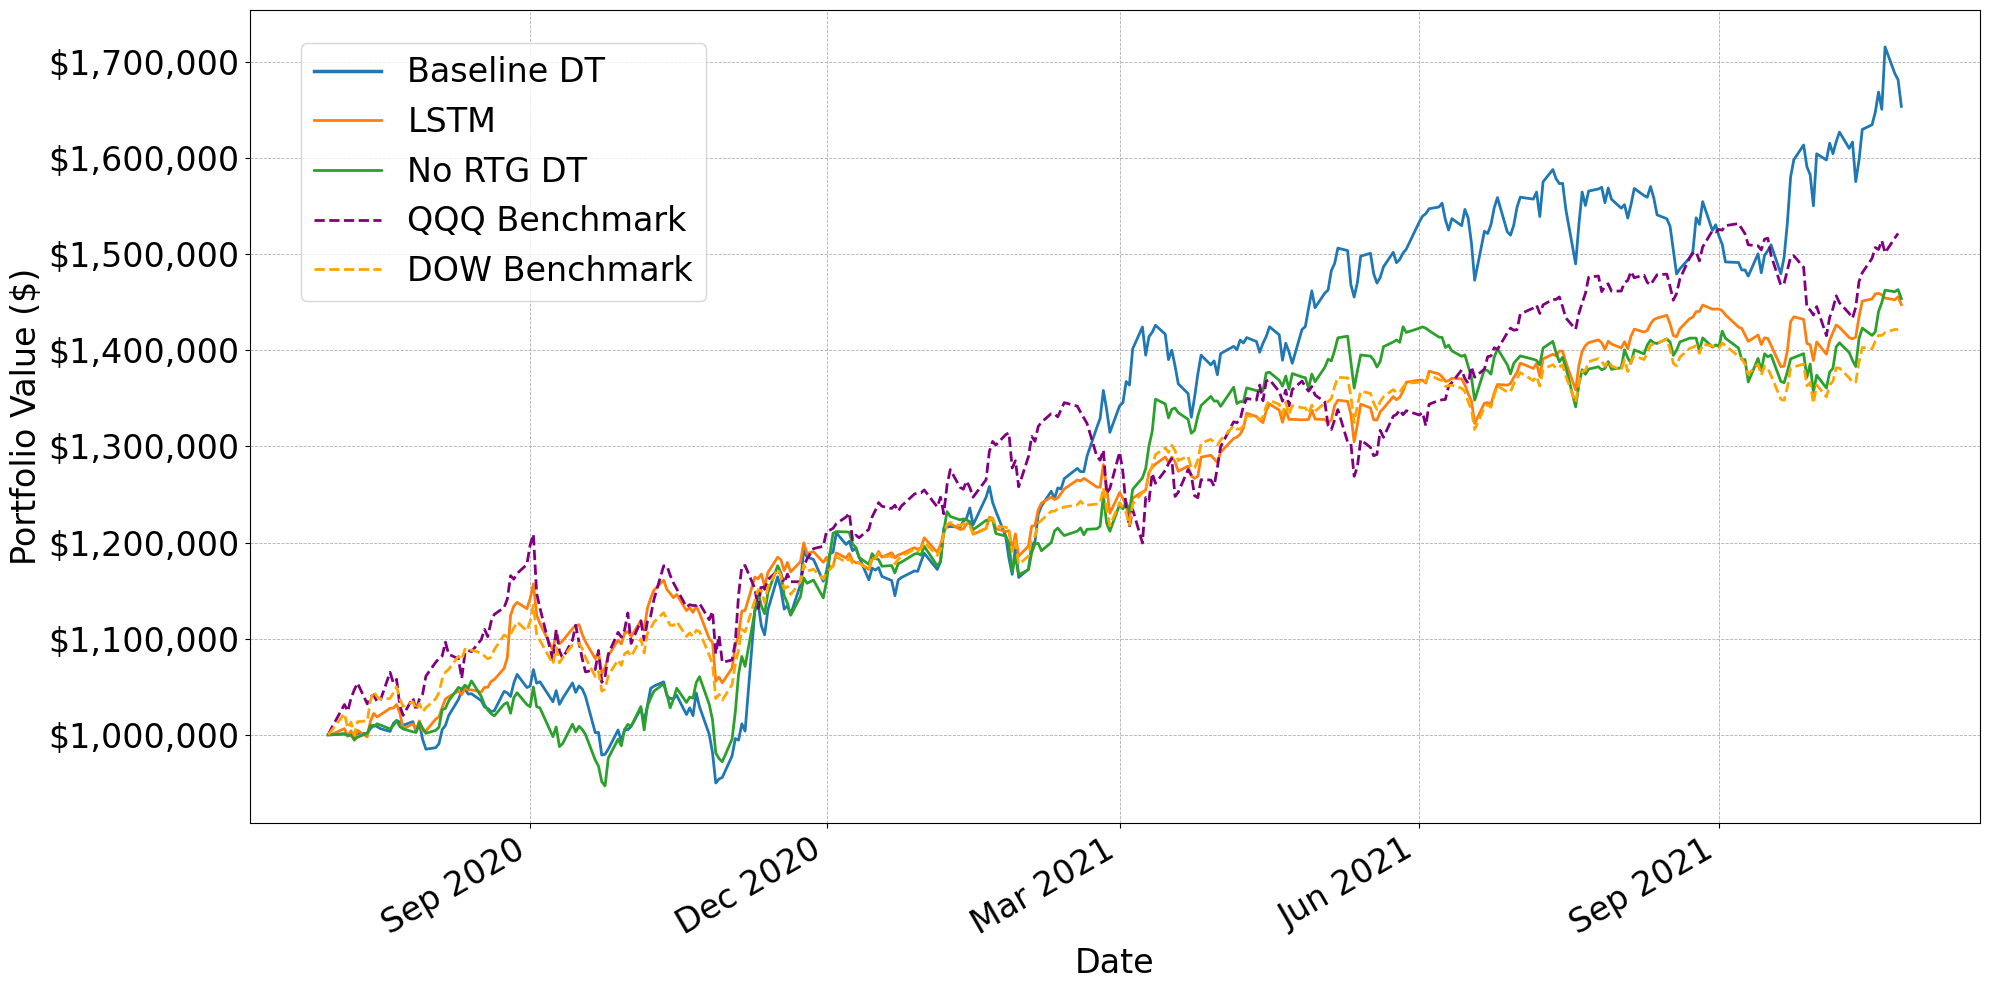

In [7]:
evaluate_and_plot_all()